## Import Packages

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
import pandas as pd
import nltk
nltk.download('stopwords')
import numpy as np
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
stop_words = set(stopwords.words('english'))
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras import backend as K
import gensim
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Attention
from keras.layers import TimeDistributed
from tensorflow.keras.layers import Layer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Dataset Loading

In [3]:
dataset = load_dataset("cnn_dailymail", "3.0.0")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [69]:
train_dataset = dataset['train'][:50000]

In [70]:
train_df = pd.DataFrame(train_dataset)


In [71]:
train_df.head()

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


## Preprocessing

### Preprocessing the text

In [72]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would","there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [73]:
def text_cleaner(text,num):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1: #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [74]:
#call the function
def cleaning_text(df):
  cleaned_text = []
  for t in df['article']:
      cleaned_text.append(text_cleaner(t,0))

  return cleaned_text


In [75]:
#call the function
def cleaning_summary(df):
  cleaned_summary = []
  for t in df['highlights']:
      cleaned_summary.append(text_cleaner(t,1))
  return cleaned_summary


In [76]:
train_df['cleaned_article'] = cleaning_text(train_df)
train_df['cleaned_highlights'] = cleaning_summary(train_df)

In [77]:
train_df.head()

,article,highlights,id,cleaned_article,cleaned_highlights
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4,london england harry potter star daniel radcli...,harry potter star daniel radcliffe gets fortun...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9,editor note behind scenes series cnn correspon...,mentally ill inmates in miami are housed on th...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37,minneapolis minnesota drivers minneapolis brid...,new thought was going to die driver says man s...
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88,washington doctors removed five small polyps p...,five small polyps found during procedure none ...
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a,national football league indefinitely suspende...,new nfl chief atlanta falcons owner critical o...


### Visualise the dataset

(array([7.3700e+02, 1.0355e+04, 2.9041e+04, 4.2758e+04, 4.6040e+04,
        4.1845e+04, 3.4018e+04, 2.5280e+04, 1.8035e+04, 1.2394e+04,
        8.9740e+03, 6.3430e+03, 4.5960e+03, 3.3940e+03, 2.0740e+03,
        8.6300e+02, 2.9000e+02, 5.8000e+01, 1.1000e+01, 2.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   4.,   68.,  132.,  196.,  260.,  324.,  388.,  452.,  516.,
         580.,  644.,  708.,  772.,  836.,  900.,  964., 1028., 1092.,
        1156., 1220., 1284., 1348., 1412., 1476., 1540., 1604., 1668.,
        1732., 1796., 1860., 1924.]),
 <BarContainer object of 30 artists>)

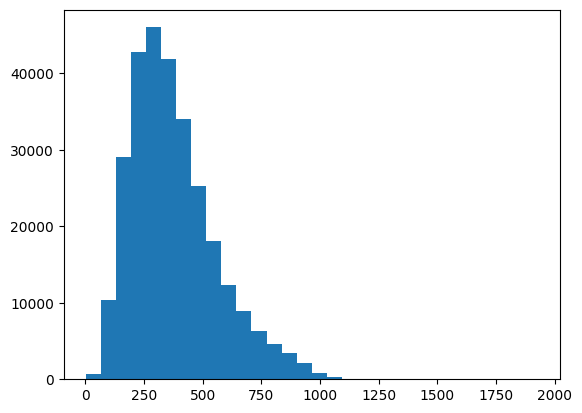

In [ ]:

text_word_count = []
summary_word_count = []

for i in train_df['cleaned_article']:
    text_word_count.append(len(i.split()))

for i in train_df['cleaned_highlights']:
    summary_word_count.append(len(i.split()))

plt.hist(text_word_count, bins=30, color='blue')

(array([1.28337e+05, 1.43433e+05, 1.36370e+04, 1.40100e+03, 1.70000e+02,
        5.80000e+01, 3.00000e+01, 1.20000e+01, 9.00000e+00, 6.00000e+00,
        5.00000e+00, 3.00000e+00, 0.00000e+00, 3.00000e+00, 3.00000e+00,
        2.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([   3. ,   41.6,   80.2,  118.8,  157.4,  196. ,  234.6,  273.2,
         311.8,  350.4,  389. ,  427.6,  466.2,  504.8,  543.4,  582. ,
         620.6,  659.2,  697.8,  736.4,  775. ,  813.6,  852.2,  890.8,
         929.4,  968. , 1006.6, 1045.2, 1083.8, 1122.4, 1161. ]),
 <BarContainer object of 30 artists>)

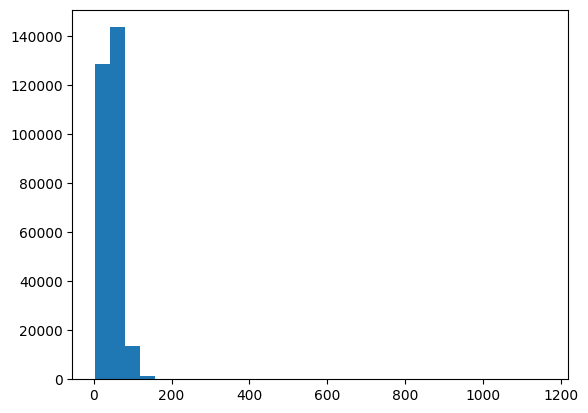

In [ ]:
plt.hist(summary_word_count, bins=30, color='salmon')

### Establishing a max_len for text and summary

In [78]:
max_summary_len = 30
max_text_len = 250

In [79]:
cleaned_text = np.array(train_df['cleaned_article'])
cleaned_summary = np.array(train_df['cleaned_highlights'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

training_df=pd.DataFrame({'text':short_text,'summary':short_summary}, )


In [80]:
training_df

,text,summary
0,police fbi agents investigating discovery empt...,empty anti tank weapon turns up in front of ne...
1,washington vice president dick cheney serve ac...,president bush will have routine colonoscopy s...
2,least people killed others wounded thursday bo...,bomb victims waiting for presidential visit bl...
3,lagos nigeria nigeria television survival show...,anthony ogadje reportedly drowned in shere hil...
4,paris france interpol monday took unprecendent...,man posted photos on the internet of himself s...
...,...,...
3934,gary david goldberg writer producer created cl...,gary david goldberg who created family ties an...
3935,new york self described ex madam claims suppli...,kristin davis is accused of peddling prescript...
3936,soccer presenter made sexist remarks female ma...,richard keys resigned from britain sky sports ...
3937,police metropolitan chicago village robbins il...,stepson says the man shot his mother brother a...


### Creating train, val and test datasets

In [81]:
training_df['summary'] = training_df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
training_df.shape

(3939, 2)

In [82]:
training_df.head()

,text,summary
0,police fbi agents investigating discovery empt...,sostok empty anti tank weapon turns up in fron...
1,washington vice president dick cheney serve ac...,sostok president bush will have routine colono...
2,least people killed others wounded thursday bo...,sostok bomb victims waiting for presidential v...
3,lagos nigeria nigeria television survival show...,sostok anthony ogadje reportedly drowned in sh...
4,paris france interpol monday took unprecendent...,sostok man posted photos on the internet of hi...


In [83]:
x_tr,x_val,y_tr,y_val=train_test_split(np.array(training_df['text']),np.array(training_df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [84]:
print(f'training samples: {len(x_tr)}')
print(f'validation samples: {len(x_val)}')

training samples: 3545
validation samples: 394


In [85]:
print((x_tr).shape)

(3545,)


### Tokenising text

In [86]:
#prepare a tokenizer
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [87]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 60.97038298807627
Total Coverage of rare words: 6.360693846000492


In [88]:
with tf.device('/device:GPU:0'):
  x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
  x_tokenizer.fit_on_texts(list(x_tr))
  x_tr_seq = x_tokenizer.texts_to_sequences(x_tr)
  x_val_seq = x_tokenizer.texts_to_sequences(x_val)

  x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
  x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')


In [89]:
x_voc   =  len(x_tokenizer.word_index) + 1
print(x_voc) #96768

36399


In [90]:
print(x_tr.shape)
print(x_val.shape)

# (2485, 300)
# (277, 300)

(3545, 250)
(394, 250)


### Tokenizing summary

In [91]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [92]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 81.64346246973365
Total Coverage of rare words: 19.58040541908831


In [93]:
with tf.device('/device:GPU:0'):
  y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
  y_tokenizer.fit_on_texts(list(y_tr))

  #convert text sequences into integer sequences
  y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
  y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

  #padding zero upto maximum length
  y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
  y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')


In [94]:
print(y_tr.shape)
print(y_val.shape)
y_voc   =  len(y_tokenizer.word_index) +1
print(y_voc)

(3545, 30)
(394, 30)
13217


## Training and Validation

### Creating DataLoaders

In [ ]:
# # Custom data loader class
# class CustomDataLoader(keras.utils.Sequence):
#     def __init__(self, x, y, batch_size):
#         self.x = x
#         self.y = y
#         self.batch_size = batch_size
#         self.num_samples = len(x)

#     def __len__(self):
#         return int(np.ceil(self.num_samples / float(self.batch_size)))

#     def __getitem__(self, idx):
#         batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
#         batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
#         return batch_x, batch_y

In [ ]:
# with tf.device('/device:GPU:0'):
#   batch_size = 256
#   train_loader = CustomDataLoader(x_tr,y_tr,batch_size)
#   val_loader = CustomDataLoader(x_val,y_val,batch_size)


## Model

We used the customed implementation of AttentionLayer which was taken from https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py

In [95]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
      with tf.device('/device:GPU:0'):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
      with tf.device('/device:GPU:0'):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """

        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
          with tf.device('/device:GPU:0'):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
          with tf.device('/device:GPU:0'):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
      with tf.device('/device:GPU:0'):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [96]:
with tf.device('/device:GPU:0'):
  K.clear_session()

  latent_dim = 25
  embedding_dim=10

  # Encoder
  encoder_inputs = Input(shape=(max_text_len,))

  #embedding layer
  enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

  #encoder lstm 1
  encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
  encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

  #encoder lstm 2
  encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True)
  encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

  #encoder lstm 3
  encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True)
  encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = Input(shape=(None,))

  #embedding layer
  dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
  dec_emb = dec_emb_layer(decoder_inputs)

  decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
  decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

  # Attention layer
  attn_layer = AttentionLayer(name='attention_layer')
  attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

  # Concat attention input and decoder LSTM output
  decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

  #dense layer
  decoder_dense =  TimeDistributed(Dense(y_voc, activation='sigmoid'))
  decoder_outputs = decoder_dense(decoder_concat_input)

In [97]:
with tf.device('/device:GPU:0'):
  # Define the model
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
  model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 250, 10)              363990    ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 250, 25),            3600      ['embedding[0][0]']           
                              (None, 25),                                                         
                              (None, 25)]                                                         
                                                                                              

In [ ]:
print(type(model))

<class 'keras.src.engine.functional.Functional'>


In [ ]:
for layer in model.layers:
    if hasattr(layer, 'weights'):
        for weight in layer.weights:
            print(f"{layer.name} weight device:", weight.device)


In [98]:
with tf.device('/device:GPU:0'):
  model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [99]:
temp_x = x_tr
temp_y = y_tr

In [100]:
with tf.device('/device:GPU:0'):

  x_tr = tf.convert_to_tensor(x_tr)
  y_tr = tf.convert_to_tensor(y_tr)

  x_val = tf.convert_to_tensor(x_val)
  y_val = tf.convert_to_tensor(y_val)

  print("Tensor device:", x_tr.device)


Tensor device: /job:localhost/replica:0/task:0/device:GPU:0


In [101]:
with tf.device('/device:GPU:0'):
  history=model.fit([x_tr,y_tr[:,:-1]], tf.reshape(y_tr, [y_tr.shape[0], y_tr.shape[1], 1])[:, 1:] ,epochs=20,batch_size=2, validation_data=([x_val,y_val[:,:-1]], tf.reshape(y_val, [y_val.shape[0], y_val.shape[1], 1])[:, 1:]))

Epoch 1/20
1773/1773 [==============================] - 234s 125ms/step - loss: 6.8583 - val_loss: 5.5237
Epoch 2/20
1773/1773 [==============================] - 191s 108ms/step - loss: 5.2539 - val_loss: 4.9443
Epoch 3/20
1773/1773 [==============================] - 185s 105ms/step - loss: 5.1234 - val_loss: 4.9414
Epoch 4/20
1773/1773 [==============================] - 183s 103ms/step - loss: 5.0867 - val_loss: 4.9014
Epoch 5/20
1773/1773 [==============================] - 183s 103ms/step - loss: 5.0465 - val_loss: 4.8746
Epoch 6/20
1773/1773 [==============================] - 182s 103ms/step - loss: 5.0101 - val_loss: 4.8531
Epoch 7/20
1773/1773 [==============================] - 186s 105ms/step - loss: 4.9736 - val_loss: 4.8285
Epoch 8/20
1773/1773 [==============================] - 185s 104ms/step - loss: 4.9408 - val_loss: 4.8030
Epoch 9/20
1773/1773 [==============================] - 184s 104ms/step - loss: 4.9094 - val_loss: 4.7744
Epoch 10/20
1773/1773 [=======================

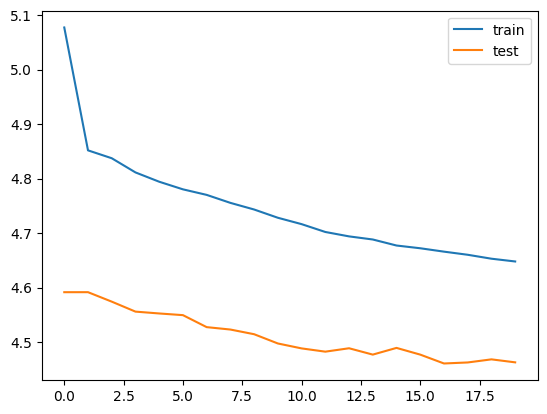

In [ ]:
# from matplotlib import pyplot
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='val')
# pyplot.legend()
# pyplot.show()
# before fine-tuning the data

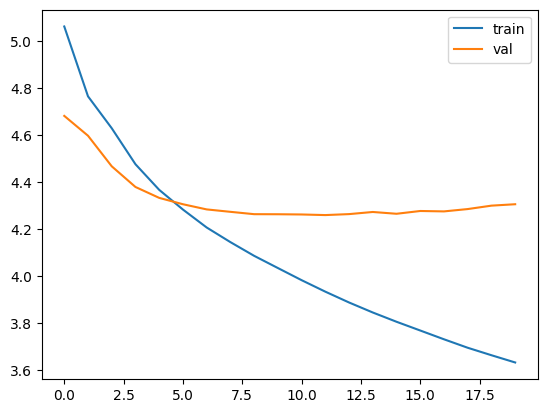

In [ ]:
# from matplotlib import pyplot
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='val')
# pyplot.legend()
# pyplot.show()
# using adam's optimizer

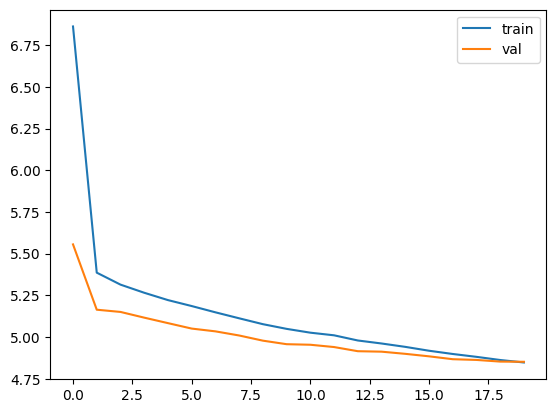

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

### Inference


In [ ]:

reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:

# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat)

decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):

    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(1, len(reverse_target_word_index) + 1):
  if reverse_target_word_index[i] == 'eostok':
    print(i)

3


In [ ]:
summaries = []
predictions = []
for i in range(0,10):
    #print("Review:",seq2text(x_tr[i]))
    summaries.append(seq2summary(y_tr[i]))
    predictions.append(decode_sequence(x_tr[i].reshape(1,max_text_len)))

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
!pip install rouge_score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=32295bf2831a84f9445f0cd36c7aef5f0e2609e844639d11e59bfbb00176653f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'])


In [ ]:
from evaluate import load

rouge = load('rouge')

# predictions = "the plane crashes on the coast of the quake was carrying passengers were injured the plane was headed to determine to the crash     "
# references = "search efforts for missing pilot suspended in pacific navy official says two the cause of the crash is under investigation navy says"

predictions = predictions
references = summaries


results = rouge.compute(predictions=predictions, references=references)

print(results)


{'rouge1': 0.30606060606060603, 'rouge2': 0.02060606060606061, 'rougeL': 0.06060606060606061, 'rougeLsum': 0.06060606060606061}


## Rough work

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Reviews.csv")

In [ ]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

In [ ]:
def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [ ]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))
cleaned_text[:5]

<ipython-input-125-20adfcf51fea>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  newString = BeautifulSoup(newString, "lxml").text


['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [ ]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(str(t),1))
cleaned_summary[:10]

<ipython-input-125-20adfcf51fea>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  newString = BeautifulSoup(newString, "lxml").text
<ipython-input-125-20adfcf51fea>:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  newString = BeautifulSoup(newString, "lxml").text


['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [ ]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [ ]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=30):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

1.0


In [ ]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=250):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.9967400142290883


In [ ]:
max_text_len=250
max_summary_len=30

In [ ]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
for i in range(5):
    print("Review:",df['text'][i])
    print("Summary:",df['summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: sostok good quality dog food eostok


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: sostok not as advertised eostok


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: sostok delight says it all eostok


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: sostok cough medicine eostok


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lover 

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.05,random_state=0,shuffle=True)

In [ ]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 68.13203937287358
Total Coverage of rare words: 0.7585067685540503


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 74.21276056516504
Total Coverage of rare words: 1.7474846743139427


In [ ]:
#prepare a tokenizer for summaries on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
df

,text,summary
0,bought several vitality canned dog food produc...,sostok good quality dog food eostok
1,product arrived labeled jumbo salted peanuts p...,sostok not as advertised eostok
2,confection around centuries light pillowy citr...,sostok delight says it all eostok
3,looking secret ingredient robitussin believe f...,sostok cough medicine eostok
4,great taffy great price wide assortment yummy ...,sostok great taffy eostok
...,...,...
392272,great sesame chicken good better resturants ea...,sostok will not do without eostok
392273,disappointed flavor chocolate notes especially...,sostok disappointed eostok
392274,stars small give one training session tried tr...,sostok perfect for our maltipoo eostok
392275,best treats training rewarding dog good groomi...,sostok favorite training and reward treat eostok


In [ ]:

reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
seq2text(x_tr[0])

'past summer started experimenting products claim give focus go pool games first one tried vitaminwater attention caffeine initially like results next week taken nap prior drinking caffeine became overwhelming played games caused rush bit shots worst performance summer long last months drinking neuro sonic prior games love gives focus need without engine much like vitaminwater attention see lot people complaining price think big deal comparing vitaminwater attention lot brain power ingredients like overcharging nothing far superior product monster red bull caffeine loaded energy drinks market gives lot focus hour energy well price tag well worth also like mix little results remarkable combo season long highest ranked player team best player team started season slow picking bit lately might catch end season keep neuro sonic combo think keep spot '

In [ ]:
seq2summary(y_tr[0])

'gives me the focus need '

In [ ]:
for i in range(0,10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,250)))
    print("\n")